**Название проекта: Определение перспективного тарифа для телеком компании**


Цель проекта: проанализировать поведение клиентов тарифов "Смарт" и "Ультра" и сделать вывод — какой из них лучше лучше.

Основные задачи:
1. Изучить общую информацию
2. Подготовить данные к работе
3. Посчитать для каждого пользователя:
    - количество сделанных звонков и израсходованных минут разговора по месяцам;
    - количество отправленных сообщений по месяцам;
    - объем израсходованного интернет-трафика по месяцам;
    - помесячную выручку с каждого пользователя.
4. Проанализировать данные 
5. Проверить гипотезы:
    - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
    - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

**Содержание:**

1. Изучение информации об имеющихся наборах данных
2. Подготовка данных
3. Анализ полученных данных
4. Проверка гипотез
5. Общий вывод по проекту

# Изучение информации об имеющихся наборах данных

## Подгрузка требуемых библиотек

In [1]:
# Первым делом подгружаем требуемые для работы библиотеки

import pandas as pd
import math
import numpy as np
from scipy import stats as st
import matplotlib
import matplotlib.pyplot as plt

## Вызов таблиц с данными

### Датасет звонков

In [2]:
# Вызываем для работы таблицу с информацией о звонках и сохраняем ее в новом датафрейме

try:
    data_calls = pd.read_csv('calls.csv')
except:
    print("Невозможно загрузить файл. Попробуй проверить путь к нему")

In [3]:
# Выводим вызванную таблицу для ее визуального осмотра

data_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
# Применяем метод info() для получения основных параметров датасета

data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
# Ну и describe() даст полезные сведения 

data_calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


**Выводы по первичному изучению данных о звонках**

Указанный датафрейм состоит из 4 столбцов, 202607 строк. Подробнее о каждом столбце можно сказать следующее:

1. id - содержит данные об уникальном номере звонка. Пропусков нет. Формат данных object корректировок не требует.
2. call_date - дата совершения звонка пользователем. Пропусков нет. Формат данных object требует корректировки и перевода в date/time для последующей работы с данными.
3. duration - длительность звонка в минутах. Пропусков нет. Формат данных float64 не требует корректировок. В дальнейшем понадобится создание нового столбца в формате int на основе текущего, в котором исходные значения будут округлены вверх для расчета прибыли компании по имеющимся тарифам (т.к. "Мегалайн" всегда производит округление длительности звонка вверх, совершая поминутную тарификацию). 

    В данном столбце присутствуют нулевые значения (почти 20 % значений), которые могут означать "недозвон" или ошибку при записи данных. Такие звонки не облагаются оплатой, а, значит, не повлияют на расчет доходов компаниии, а также не будут учитываться при получении общей продолжительности разговоров для пользователей. Для подсчета общего количества "успешных" вызовов можно будет сделать срез по ненулевым значениям. Нули можно оставить.
4. user_id - идентификатор пользователя, сделавшего звонок. Пропусков нет. Формат данных int корректировок не требует.
</div>

### Данные об использовании интернета

In [6]:
# Вызываем для работы таблицу с информацией об интернет-трафике и сохраняем ее в новом датафрейме

try:
    data_internet = pd.read_csv('internet.csv')
except:
    print("Невозможно загрузить файл. Попробуй проверить путь к нему")

In [7]:
# Вызываем таблицу для визуального осмотра

data_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [8]:
data_internet['mb_used'].value_counts()

0.00      19598
335.91        9
447.30        9
197.56        9
199.11        8
          ...  
182.69        1
726.03        1
315.12        1
898.99        1
677.66        1
Name: mb_used, Length: 70003, dtype: int64

In [9]:
# Применяем метод info() для получения доп. параметров датасета

data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [10]:
# И Describe() не помешает

data_internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


**Выводы по первичному изучению данных об использовании интернета**

Данный датафрейм содержит 5 столбцов и 149396 строк. Подробнее о столбцах можно сообщить следующее:

1. Unnamed: 0 - столбец не отмечен в задании и полностью дублирует индексы датафрейма. Мог быть создан случайно при формировании таблицы. Имеет смысл его жесточайшим образом уничтожить, чтобы не "путался под ногами" у серьезных дядек.
2. id - уникальный номер сессии. Не содержит пропусков. Формат данных object не требует корректировок.
3. mb_used - объем потраченного за сессию интернет-трафика (в мегабайтах). Пропусков не содержит. Формат данных float64 корректировок не требует, однако, учитывая тягу "Мегалайна" к округлению трафика вверх, в дальнейшем понадобится новый столбец, содержащий округленные указанным образом значения,  записанные в формате int.
    
    Данный столбец содержит нулевые значения (прим. 13 %). Самым простым вариантом причины их появления может быть банальное неиспользование интернета. Достаточно часто это происходит у пожилых людей старше 65 лет, которые применяют телефон только для связи с родными и друзьями посредством обычных звонков. Срез по данным о пользователях по критерию "старше 65 лет" дает количество в 89 юзеров, что соответствует 13 процентам от общего числа пользователей. Таким образом, делаем предположение о том, что нули действительно означают неиспользование интернет-трафика и оставляем их как есть. На подсчеты прибыли компании они не повлияют.

4. session_date - дата интернет-сессии. Пропусков не имеет. Формат данных object требует преобразования в формат date/time.
5. user_id - уникальный идентификатор пользователя. Пропусков нет. Формат данных Int64 не требует коррекции.
</div>

### Таблица с данными об использовании текстовых сообщений

In [11]:
# Вызываем для работы таблицу с информацией об использовании СМС и сохраняем ее в новом датафрейме

try:
    data_messages = pd.read_csv('messages.csv')
except:
    print("Невозможно загрузить файл. Попробуй проверить путь к нему")

In [12]:
# Выводим таблицу для визуального осмотра

data_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [13]:
# Не упускаем метод info()

data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


**Выводы по первичному изучению данных об использовании текстовых сообщений**

Данная таблица содержит 3 столбца, 123036 строк. Побдробнее о каждом столбце можно сообщить следующее:
    
1. id - уникальный номер сообщения. Пропусков нет. Формат данных object корректировки не требует.
2. message_date - дата сообщения. Пропусков нет. Формат данных object требует замены на date/time.
3. user_id - идентификатор пользователя, отправившего сообщение. Пропусков не имеется. Формат данных int64 корректировок не просит.

### Условия использования тарифов

In [14]:
# Вызываем для работы таблицу с информацией об условиях тарифа и сохраняем ее в новом датафрейме

try:
    data_tariffs = pd.read_csv('tariffs.csv')
except:
    print("Невозможно загрузить файл. Попробуй проверить путь к нему")

In [15]:
# Вызываем таблицу для визуального осмотра

data_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [16]:
# Используем метод info()

data_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


**Выводы по первичному изучению таблицы со сведениями об условиях тарифов**

Датасет содержит 8 столбцов и АЖ 2 строки, пропусков нет, форматировать данные не надо (ну чудо, не так ли? LittleBig Data). Пропусков нет. Разберем же содержимое столбцов:

1. messages_included - количество сообщений в месяц, включенных в абонентскую плату.
2. mb_per_month_included - объем интернет-трафика, включенного в абонентскую плату (в мегабайтах).
3. minutes_included - количество минут разговора в месяц, включенных в абонентскую плату.
4. rub_monthly_fee - ежемесячная абонентская плата в рублях.
5. rub_per_gb -  стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта).
6. rub_per_message - стоимость отправки сообщения сверх тарифного пакета.
7. rub_per_minute - стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата).
8. tariff_name - название тарифа. 
</div>

### Таблица с данными о пользователях

In [17]:
# Вызываем таблицу с информацией о пользователях и сохраняем ее в новом датафрейме

try:
    data_users = pd.read_csv('users.csv')
except:
    print("Невозможно загрузить файл. Попробуй проверить путь к нему")

In [18]:
# Производим визуальный осмотр датасета

data_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [19]:
# Дополнительные параметры получаем через метод info()

data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [20]:
# Не ленимся посмотреть, что покажет метод describe()

data_users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


**Выводы по первичному изучению данных о пользователях**

Данная таблица содержит 8 столбцов и 500 строк. Подробнее о столбцах ниже:

1. user_id - уникальный идентификатор пользователя. Пропусков нет. Формат данных int64 корректировок не требует.
2. age — возраст пользователя (годы). Пропусков нет. Формат данных int64 корректировок не требует.
3. churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных). Столбец содержит всего 38 ненулевых значений, но заполнений не требует, так как отсутствие сведений в данном случае не говорит о какой-либо ошибке, а показывает, что пользователь все еще пользуется услугами данного тарифа. Формат данных object требует перевода в тип date/time.
4. city — город проживания пользователя. Пропусков нет. Формат данных object не требует корректировок.
5. first_name — имя пользователя. Пропусков нет. Формат данных object не требует корректировок.
6. last_name — фамилия пользователя. Пропусков нет. Формат данных object не требует корректировок.
7. reg_date — дата подключения тарифа (день, месяц, год). Пропусков нет. Формат данных object требует перевода в тип date/time.
8. tariff — название тарифного плана. Пропусков нет. Формат данных object не требует корректировок. 
</div>

### Общий вывод по разделу

В данном разделе был подготовлен необходимый инструментарий для проведения анализа данных. Вызваны необходимые библиотеки, функции из которых будут использованы далее в расчетах. Загружены требуемые датасеты. Проведен первичный анализ имеющихся данных для получения представлении об их качественном составе, наличии ошибок и пропусков, высказаны предложения по последующей работе по подготовке этих сведений к анализу.

# Подготовка данных

## Изменение типа данных в столбцах, содержащих сведения о датах

In [21]:
# Переведем данные столбца call_date в датафрейме с данными о звонках в формат date/time

data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y.%m.%dT%H:%M:%S')

In [22]:
# Проверяем результат корректировки формата данных

data_calls['call_date'].head(1)

0   2018-07-25
Name: call_date, dtype: datetime64[ns]

In [23]:
# Переведем данные столбца session_date в датафрейме с информацией об интернете в формат date/time

data_internet['session_date'] = (pd.to_datetime(data_internet['session_date'],
                                                format='%Y.%m.%dT%H:%M:%S'))

In [24]:
# Проверяем результат корректировки формата данных

data_internet['session_date'].head(1)

0   2018-11-25
Name: session_date, dtype: datetime64[ns]

In [25]:
# Переведем данные столбца data_messages в датафрейме о сообщениях в формат date/time

data_messages['message_date'] = (pd.to_datetime(data_messages['message_date'], 
                                                format='%Y.%m.%dT%H:%M:%S'))

In [26]:
# Проверяем результат корректировки формата данных

data_messages['message_date'].head(1)

0   2018-06-27
Name: message_date, dtype: datetime64[ns]

In [27]:
# Переведем данные столбца churn_date в датафрейме о пользователях в формат date/time

data_users['churn_date'] = pd.to_datetime(data_users['churn_date'], format='%Y.%m.%dT%H:%M:%S')

In [28]:
# Проверяем результат корректировки формата данных

data_users['churn_date'].tail(1)

499   NaT
Name: churn_date, dtype: datetime64[ns]

In [29]:
# Переведем данные столбца reg_date в датафрейме о пользователях в формат date/time

data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y.%m.%dT%H:%M:%S')

In [30]:
# Проверяем результат корректировки формата данных

data_users['reg_date'].head(1)

0   2018-05-25
Name: reg_date, dtype: datetime64[ns]

## Округление данных о длительности звонков и использовании интернет-трафика

In [31]:
# Создадим в таблице data_calls новый столбец, который будет содержать 
# округленные вверх значения длительности звонка

data_calls['duration_rounded'] = np.ceil(data_calls['duration'])

In [32]:
# Проверим наличие созданного столбца в таблице

data_calls.head(1)

,id,call_date,duration,user_id,duration_rounded
0,1000_0,2018-07-25,0.0,1000,0.0


In [33]:
# Создадим в таблице data_internet новый столбец, который будет содержать 
# округленные вверх сведения об использовании трафика

data_internet['mb_used_rounded'] = np.ceil(data_internet['mb_used'])

In [34]:
# Выведем полученную таблицу для проверки результата

data_internet.head(1)

,Unnamed: 0,id,mb_used,session_date,user_id,mb_used_rounded
0,0,1000_0,112.95,2018-11-25,1000,113.0


## Удаление лишнего столбца из данных об использовании интернет-трафика

In [35]:
# Для удаления "лишнего" столбца Unnamed: 0 воспользуемся методом drop()

data_internet = data_internet.drop(['Unnamed: 0'], axis = 1)

In [36]:
# Вызываем датасет для проверки результата удаления

data_internet.head(1)

,id,mb_used,session_date,user_id,mb_used_rounded
0,1000_0,112.95,2018-11-25,1000,113.0


## Объединение таблиц для дальнейшей работы с ними

### Данные о звонках

In [37]:
# Для того, чтобы в дальнейшей работе иметь полное представление о каждом пользователе 
# и совершенных ими звонках, объединим соответствующие таблицы

calls_users_merged = data_calls.merge(data_users, on = "user_id", how = 'outer')

In [38]:
# Проверяем результаты слияния

calls_users_merged.head()

,id,call_date,duration,user_id,duration_rounded,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000_0,2018-07-25,0.00,1000,0.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000_1,2018-08-17,0.00,1000,0.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000_2,2018-06-11,2.85,1000,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000_3,2018-09-21,13.80,1000,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000_4,2018-12-15,5.18,1000,6.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [39]:
# Проверяем количество пользователей (должно быть 500)

len(calls_users_merged['user_id'].unique())

500

### Данные о сообщениях

In [40]:
# С теми же целями объединим датафреймы с данными о пользователях и о сообщениях

messages_users_merged = data_messages.merge(data_users, on = "user_id", how = 'outer')

In [41]:
# Проверяем результаты слияния таблиц

messages_users_merged.head()

,id,message_date,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000_0,2018-06-27,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000_1,2018-10-08,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000_2,2018-08-04,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000_3,2018-06-16,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000_4,2018-12-05,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [42]:
# Проверяем количество пользователей (должно быть 500)

len(messages_users_merged['user_id'].unique())

500

### Данные об интернет-трафике

In [43]:
# Повторяем процедуру для данных об интернет-трафике

internet_users_merged = data_internet.merge(data_users, on = "user_id", how = 'outer')

In [44]:
# Проверяем результаты слияния таблиц

internet_users_merged.head()

,id,mb_used,session_date,user_id,mb_used_rounded,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000_0,112.95,2018-11-25,1000,113.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000_1,1052.81,2018-09-07,1000,1053.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000_2,1197.26,2018-06-25,1000,1198.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000_3,550.27,2018-08-22,1000,551.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000_4,302.56,2018-09-24,1000,303.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [45]:
# Проверяем количество пользователей (должно быть 500)

len(internet_users_merged['user_id'].unique())

500

## Добавление в рабочие таблицы информации о месяце совершения действия пользователем

In [46]:
# Добавим в таблицу с данными о звонках столбец с месяцем совершения вызова

calls_users_merged['month'] = pd.DatetimeIndex(calls_users_merged['call_date']).month

In [47]:
calls_users_merged.head()

,id,call_date,duration,user_id,duration_rounded,age,churn_date,city,first_name,last_name,reg_date,tariff,month
0,1000_0,2018-07-25,0.00,1000,0.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0
1,1000_1,2018-08-17,0.00,1000,0.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0
2,1000_2,2018-06-11,2.85,1000,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0
3,1000_3,2018-09-21,13.80,1000,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0
4,1000_4,2018-12-15,5.18,1000,6.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12.0


In [48]:
# Добавляем в датасет с информацией о сообщениях столбец с данными о месяце отправки СМС

messages_users_merged['month'] = pd.DatetimeIndex(messages_users_merged['message_date']).month

In [49]:
# Выводим таблицу для проверки

messages_users_merged.head()

,id,message_date,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month
0,1000_0,2018-06-27,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0
1,1000_1,2018-10-08,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,10.0
2,1000_2,2018-08-04,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0
3,1000_3,2018-06-16,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0
4,1000_4,2018-12-05,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12.0


In [50]:
# Добавляем в датасет с информацией об интернет-трафике сообщениях столбец с данными о месяце использования интернета

internet_users_merged['month'] = pd.DatetimeIndex(internet_users_merged['session_date']).month

In [51]:
# Вызываем датасет интернет-трафика для проверки результатов

internet_users_merged.head()

,id,mb_used,session_date,user_id,mb_used_rounded,age,churn_date,city,first_name,last_name,reg_date,tariff,month
0,1000_0,112.95,2018-11-25,1000,113.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,11.0
1,1000_1,1052.81,2018-09-07,1000,1053.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0
2,1000_2,1197.26,2018-06-25,1000,1198.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0
3,1000_3,550.27,2018-08-22,1000,551.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0
4,1000_4,302.56,2018-09-24,1000,303.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0


## Статистика тарифа Smart

### Звонки

In [52]:
# Формируем таблицу, в которой будут записаны данные 
# о продолжительности разговоров пользователей
# тарифа smart по месяцам

calls_stats_smart  = (calls_users_merged.query('tariff == "smart"')
                                   .pivot_table(index = ['user_id',
                                                         'month',
                                                         'tariff',
                                                         'city'],
                                                values = ['duration_rounded'], 
                                                aggfunc = 'sum'))

In [53]:
# Переименовываем полученный столбец для наглядности

calls_stats_smart.columns = ['minutes_total']

In [54]:
# Выводим полученный датасет для контроля качества

calls_stats_smart.head()

minutes_total
user_id month tariff city                      
1001    11.0  smart  Москва               430.0
        12.0  smart  Москва               414.0
1002    6.0   smart  Стерлитамак          117.0
        7.0   smart  Стерлитамак          214.0
        8.0   smart  Стерлитамак          289.0

In [55]:
# Из полученных данных получаем те, которые превышают месячный лимит разговоров по тарифу
# затем вычитаем из них этот лимит, а результат умножаем на стоимость минуты.
# Пропуски заменяем нулями.

calls_stats_smart['minutes_revenue'] = (((calls_stats_smart[calls_stats_smart > data_tariffs['minutes_included'][0]])
                                         - data_tariffs['minutes_included'][0])
                                        * data_tariffs['rub_per_minute'][0]).fillna(0)


In [56]:
# Формируем таблицу, в которой будут записаны данные 
# о количестве "успешных" звонков пользователей
# тарифа smart по месяцам

calls_stats_smart['calls_count']  = (calls_users_merged.query('tariff == "smart" and duration_rounded > 0')
                                   .pivot_table(index = ['user_id',
                                                         'month',
                                                         'tariff',
                                                         'city'],
                                                values = ['duration_rounded'], 
                                                aggfunc = 'count'))

In [57]:
# Выводим результат

calls_stats_smart.tail()

minutes_total  minutes_revenue  calls_count
user_id month tariff city                                                    
1498    10.0  smart  Владикавказ          247.0              0.0         30.0
1499    9.0   smart  Пермь                 70.0              0.0          8.0
        10.0  smart  Пермь                449.0              0.0         44.0
        11.0  smart  Пермь                612.0            336.0         62.0
        12.0  smart  Пермь                492.0              0.0         56.0

### СМС

In [58]:
# Посчитаем количество сообщений каждого пользователя по месяцам

messages_stats_smart = (messages_users_merged.query('tariff == "smart"')
                            .pivot_table(index = ['user_id', 
                                                  'month',
                                                  'tariff',
                                                  'city'], 
                                         values = 'id',
                                         aggfunc = 'count'))

In [59]:
# Переименовываем полученный столбец для наглядности

messages_stats_smart.columns = ['sms_total']

In [60]:
# Выводим таблицу для проверки результата отбора

messages_stats_smart.head()

sms_total
user_id month tariff city                  
1002    6.0   smart  Стерлитамак          4
        7.0   smart  Стерлитамак         11
        8.0   smart  Стерлитамак         13
        9.0   smart  Стерлитамак          4
        10.0  smart  Стерлитамак         10

In [61]:
# Из полученных данных получаем те, которые превышают месячный лимит СМС по тарифу
# затем вычитаем из них месячный лимит, а результат умножаем на стоимость
# сообщения. Пропуски заменяем нулями.

messages_stats_smart['sms_revenue'] = (((messages_stats_smart[messages_stats_smart > data_tariffs['messages_included'][0]])
                                         - data_tariffs['messages_included'][0])
                                        * data_tariffs['rub_per_message'][0]).fillna(0)

In [62]:
# Смотрим результаты 

messages_stats_smart.tail()

sms_total  sms_revenue
user_id month tariff city                               
1498    10.0  smart  Владикавказ         42          0.0
1499    9.0   smart  Пермь               11          0.0
        10.0  smart  Пермь               48          0.0
        11.0  smart  Пермь               59         27.0
        12.0  smart  Пермь               66         48.0

### Интернет

In [63]:
# Считаем объем израсходанного интернет-трафика для каждого пользователя по месяцам.
# Как и в случае со звонками, используем округленные вверх данные, так как "Мегалайн" считает
# только мегабайты, а не их доли.

internet_stats_smart = (internet_users_merged.query('tariff == "smart"')
                                    .pivot_table(index = ['user_id', 'month', 'tariff', 'city'], 
                                    values = 'mb_used_rounded',
                                    aggfunc = 'sum'))

In [64]:
# Переименовываем полученный столбец для наглядности

internet_stats_smart.columns = ['mb_total']

In [65]:
# Выводим текущий результат

internet_stats_smart.head()

mb_total
user_id month tariff city                 
1001    11.0  smart  Москва        18452.0
        12.0  smart  Москва        14053.0
1002    6.0   smart  Стерлитамак   10871.0
        7.0   smart  Стерлитамак   17601.0
        8.0   smart  Стерлитамак   20347.0

In [66]:
# Из полученных данных получаем те, которые превышают месячный лимит мегабайт по тарифу
# затем вычитаем из них месячный лимит, а результат умножаем на стоимость
# 1 Мб. Пропуски заменяем нулями.

internet_stats_smart['mb_revenue'] = (((internet_stats_smart[internet_stats_smart > data_tariffs['mb_per_month_included'][0]])
                                      - data_tariffs['mb_per_month_included'][0])
                                     * data_tariffs['rub_per_gb'][0] / 1024).fillna(0) 

In [67]:
# Смотрим, что получили

internet_stats_smart.head()

mb_total  mb_revenue
user_id month tariff city                             
1001    11.0  smart  Москва        18452.0  603.906250
        12.0  smart  Москва        14053.0    0.000000
1002    6.0   smart  Стерлитамак   10871.0    0.000000
        7.0   smart  Стерлитамак   17601.0  437.695312
        8.0   smart  Стерлитамак   20347.0  974.023438

### Общий доход

In [68]:
# Напишем общую функцию для поиска дохода компании по всем видам услуг по каждому 
# пользователя помесячно. Результат добавляется в качестве нового столбца в таблицу 

def count_revenue(tariff):
    
    if tariff == 'smart':
        sign = 0
        data = smart_stats
    
    elif tariff == 'ultra':
        sign = 1
        data = ultra_stats
    
    else:
        print('Некорректно задано название тарифа. Попробуйте написать его строчными латинскими буквами')

    return (data['minutes_revenue'] + data['sms_revenue'] 
                                    + data['mb_revenue'] 
                                    + data_tariffs['rub_monthly_fee'][sign])

In [69]:
# Сводим все данные по тарифу Смарт в одну таблицу путем объединения статистики по звонкам,
# СМС и трафику

smart_stats = calls_stats_smart.join(messages_stats_smart['sms_revenue'], how='outer')

smart_stats = smart_stats.join(internet_stats_smart['mb_revenue'], how='outer')

In [70]:
# Пропуски заполняем нулями

smart_stats = smart_stats.fillna(0)

In [71]:
# Складываем доход по всем видам связи и прибавляем к результату абонентскую плату по тарифу

smart_stats['revenue_total'] = count_revenue('smart')

In [72]:
# Выводим результат

smart_stats.head()

minutes_total  minutes_revenue  calls_count  \
user_id month tariff city                                                       
1001    11.0  smart  Москва               430.0              0.0         45.0   
        12.0  smart  Москва               414.0              0.0         47.0   
1002    6.0   smart  Стерлитамак          117.0              0.0         14.0   
        7.0   smart  Стерлитамак          214.0              0.0         21.0   
        8.0   smart  Стерлитамак          289.0              0.0         37.0   

                                  sms_revenue  mb_revenue  revenue_total  
user_id month tariff city                                                 
1001    11.0  smart  Москва               0.0  603.906250    1153.906250  
        12.0  smart  Москва               0.0    0.000000     550.000000  
1002    6.0   smart  Стерлитамак          0.0    0.000000     550.000000  
        7.0   smart  Стерлитамак          0.0  437.695312     987.695312  
        8.0   smart  Стерлитамак          0.0  974.023438    1524.023438

## Статистика тарифа Ultra

### Звонки

In [73]:
# Формируем таблицу, в которой будут записаны данные о продолжительности разговоров 
# пользователей тарифа Ульра по месяцам

calls_stats_ultra  = (calls_users_merged.query('tariff == "ultra"')
                                   .pivot_table(index = ['user_id', 'month', 'tariff', 'city'],
                                                values = ['duration_rounded'], 
                                                aggfunc = 'sum'))

In [74]:
# Переименовываем полученный столбец для наглядности

calls_stats_ultra.columns = ['minutes_total']

In [75]:
# Выводим полученный датасет для контроля качества

calls_stats_ultra.head()

minutes_total
user_id month tariff city                    
1000    5.0   ultra  Краснодар          159.0
        6.0   ultra  Краснодар          172.0
        7.0   ultra  Краснодар          340.0
        8.0   ultra  Краснодар          408.0
        9.0   ultra  Краснодар          466.0

In [76]:
# Из полученных данных получаем те, которые превышают месячный лимит разговоров по тарифу
# затем вычитаем из них месячный лимит минут по тарифу, а результат умножаем на стоимость
# минуты. Пропуски заменяем нулями.

calls_stats_ultra['minutes_revenue'] = (((calls_stats_ultra[calls_stats_ultra > data_tariffs['minutes_included'][1]])
                                         - data_tariffs['minutes_included'][1])
                                        * data_tariffs['rub_per_minute'][1]).fillna(0)


In [77]:
# Выводим результат

calls_stats_ultra.head()

minutes_total  minutes_revenue
user_id month tariff city                                     
1000    5.0   ultra  Краснодар          159.0              0.0
        6.0   ultra  Краснодар          172.0              0.0
        7.0   ultra  Краснодар          340.0              0.0
        8.0   ultra  Краснодар          408.0              0.0
        9.0   ultra  Краснодар          466.0              0.0

### СМС

In [78]:
# Посчитаем количество сообщений каждого пользователя по месяцам

messages_stats_ultra = (messages_users_merged.query('tariff == "ultra"')
                            .pivot_table(index = ['user_id', 'month', 'tariff', 'city'], 
                             values = 'id',aggfunc = 'count').sort_values(by = 'user_id'))

In [79]:
# Переименовываем полученный столбец для наглядности

messages_stats_ultra.columns = ['sms_total']

In [80]:
# Выводим таблицу для проверки результата отбора

messages_stats_ultra.head()

sms_total
user_id month tariff city                
1000    5.0   ultra  Краснодар         22
        6.0   ultra  Краснодар         60
        7.0   ultra  Краснодар         75
        8.0   ultra  Краснодар         81
        9.0   ultra  Краснодар         57

In [81]:
# Из полученных данных получаем те, которые превышают месячный лимит СМС по тарифу
# затем вычитаем из них месячный лимит, а результат умножаем на стоимость
# сообщения. Пропуски заменяем нулями.

messages_stats_ultra['sms_revenue'] = (((messages_stats_ultra[messages_stats_ultra > data_tariffs['messages_included'][1]])
                                         - data_tariffs['messages_included'][1])
                                        * data_tariffs['rub_per_message'][1]).fillna(0)

In [82]:
# Смотрим результаты 

messages_stats_ultra.tail()

sms_total  sms_revenue
user_id month tariff city                           
1495    11.0  ultra  Иркутск         79          0.0
        8.0   ultra  Иркутск         13          0.0
        9.0   ultra  Иркутск         82          0.0
        10.0  ultra  Иркутск         82          0.0
        12.0  ultra  Иркутск         84          0.0

### Интернет

In [83]:
# Считаем объем израсходанного интернет-трафика для каждого пользователя по месяцам.
# Как и в случае со звонками, используем округленные вверх данные, так как "Мегалайн" считает
# только мегабайты, а не их доли.

internet_stats_ultra = (internet_users_merged.query('tariff == "ultra"')
                                    .pivot_table(index = ['user_id', 'month', 'tariff', 'city'], 
                                    values = 'mb_used_rounded',
                                    aggfunc = 'sum'))

In [84]:
# Переименовываем полученный столбец для наглядности

internet_stats_ultra.columns = ['mb_total']

In [85]:
# Выводим текущий результат

internet_stats_ultra.head()

mb_total
user_id month tariff city               
1000    5.0   ultra  Краснодар    2256.0
        6.0   ultra  Краснодар   23257.0
        7.0   ultra  Краснодар   14016.0
        8.0   ultra  Краснодар   14070.0
        9.0   ultra  Краснодар   14581.0

In [86]:
# Из полученных данных получаем те, которые превышают месячный лимит мегабайт по тарифу
# затем вычитаем из них месячный лимит, а результат умножаем на стоимость
# Мб. Пропуски заменяем нулями.

internet_stats_ultra['mb_revenue'] = (((internet_stats_ultra[internet_stats_ultra > data_tariffs['mb_per_month_included'][1]])
                                      - data_tariffs['mb_per_month_included'][1])
                                     * data_tariffs['rub_per_gb'][1] / 1024).fillna(0) 

In [87]:
# Смотрим, что получили

internet_stats_ultra.head()

mb_total  mb_revenue
user_id month tariff city                           
1000    5.0   ultra  Краснодар    2256.0         0.0
        6.0   ultra  Краснодар   23257.0         0.0
        7.0   ultra  Краснодар   14016.0         0.0
        8.0   ultra  Краснодар   14070.0         0.0
        9.0   ultra  Краснодар   14581.0         0.0

### Общий доход

In [88]:
# Сводим все данные по тарифу Смарт в одну таблицу путем объединения статистики по звонкам,
# СМС и трафику

ultra_stats = calls_stats_ultra.join(messages_stats_ultra['sms_revenue'], how='outer')

ultra_stats = ultra_stats.join(internet_stats_ultra['mb_revenue'], how='outer')

In [89]:
# Пропуски заполняем нулями

ultra_stats = ultra_stats.fillna(0)

In [90]:
# Складываем доход по всем видам связи и прибавляем к результату абонентскую плату по тарифу

ultra_stats['revenue_total'] = count_revenue('ultra')

In [91]:
# Выводим результат

ultra_stats.head()

minutes_total  minutes_revenue  sms_revenue  \
user_id month tariff city                                                     
1000    5.0   ultra  Краснодар          159.0              0.0          0.0   
        6.0   ultra  Краснодар          172.0              0.0          0.0   
        7.0   ultra  Краснодар          340.0              0.0          0.0   
        8.0   ultra  Краснодар          408.0              0.0          0.0   
        9.0   ultra  Краснодар          466.0              0.0          0.0   

                                mb_revenue  revenue_total  
user_id month tariff city                                  
1000    5.0   ultra  Краснодар         0.0         1950.0  
        6.0   ultra  Краснодар         0.0         1950.0  
        7.0   ultra  Краснодар         0.0         1950.0  
        8.0   ultra  Краснодар         0.0         1950.0  
        9.0   ultra  Краснодар         0.0         1950.0

## Вывод по разделу

В данном разделе была проведена работа по подготовке данных к дальнейшему анализу. В частности, осуществлены следующие мероприятия:
- коррекция типа данных в столбцах дат осуществления пользователем каких-либо действий;
- округлены вверх минуты и мегабайты для перерасчета в дальнейшем в прибыль для компании;
- удален лишний столбец из датасета data_internet;
- объединены таблицы со сведениями о звонках, использовании интернет-трафика, сообщениях с датасетом информации о пользователях;
- из информации о датах совершения действий пользователями сформирован отдельный столбец, в котором эти сведения категоризированы по месяцам;
- рассчитаны помесячные показатели использования пользователями услуг компании и их расходы по данным действиям (общая продолжительность разговоров, объем интернет-трафика, количество отправленных СМС);
- оценены общие доходы компании по каждому пользователю помесячно.

# Анализ полученных данных

## Тариф СМАРТ

### Длительность звонков

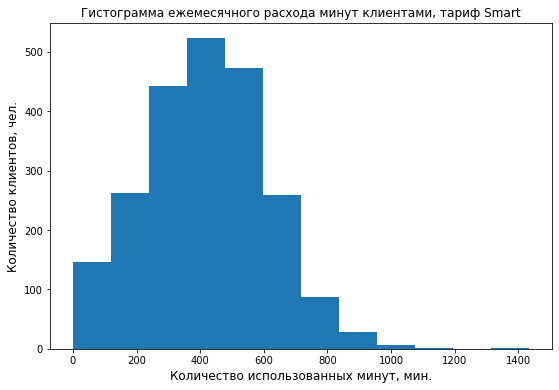

In [92]:
# Построим гистограмму количества потраченных минут звонков пользователей по месяцам

smart_stats['minutes_total'].plot(kind = 'hist', 
                                  bins = 12, 
                                  figsize = (9, 6)).set_title('Гистограмма ежемесячного расхода минут клиентами, тариф Smart')
plt.xlabel('Количество использованных минут, мин.', fontsize=12)
plt.ylabel('Количество клиентов, чел.', fontsize=12)
plt.show()

Данная гистограмма имеет четко выраженное стремление к нормальному виду. Это говорит об адекватности имеющихся данных и позволит в дальнейшем оценивать по данной выборке параметры генеральной совокупности.

In [93]:
# Посчитаем среднее по длительности звонков

smart_stats['minutes_total'].mean()

417.9349484073576

In [94]:
# Сделаем расчет дисперсии средней длительности звонков

smart_stats['minutes_total'].var()

36219.31578434428

In [95]:
# Рассчитаем стандартное отклонение длительности звонков тарифа Smart

smart_stats['minutes_total'].std()

190.31372988921288

### Количество сообщений

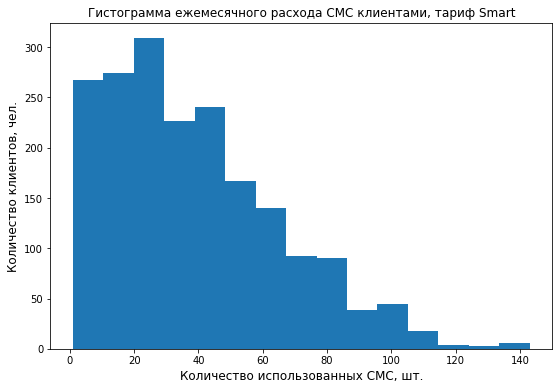

In [96]:
# Представим полученные данные в виде гистограммы

messages_stats_smart['sms_total'].plot(kind = 'hist',
                                       bins = 15,
                                       figsize = (9, 6)).set_title('Гистограмма ежемесячного расхода СМС клиентами, тариф Smart')
plt.xlabel('Количество использованных СМС, шт.', fontsize=12)
plt.ylabel('Количество клиентов, чел.', fontsize=12)
plt.show()

In [97]:
# Посчитаем среднее по использованию СМС

messages_stats_smart['sms_total'].mean()

38.71644120707596

In [98]:
# Рассчитаем годовую дисперсию

messages_stats_smart['sms_total'].var()

717.5942011753547

In [99]:
# Получим годовое стандартное отклонение

messages_stats_smart['sms_total'].std()

26.787948804926344

### Интернет-трафик

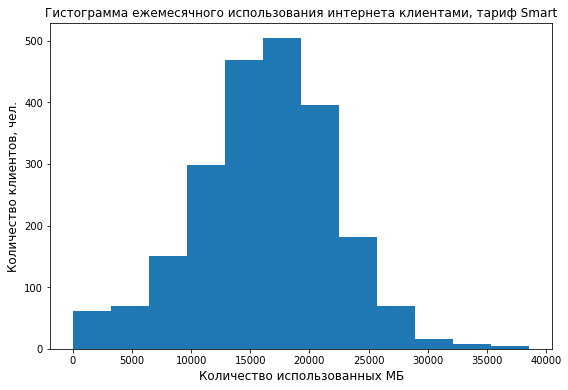

In [100]:
# Построим гистограмму помесячного расхода интернет-трафика

internet_stats_smart['mb_total'].plot(kind = 'hist',
                                      bins = 12,
                                      figsize = (9, 6)).set_title('Гистограмма ежемесячного использования интернета клиентами, тариф Smart')
plt.xlabel('Количество использованных МБ', fontsize=12)
plt.ylabel('Количество клиентов, чел.', fontsize=12)
plt.show()

Полученная гистограмма стремится по форме к нормальному распределению.

In [101]:
# Получим среднее количество израсходованного трафика

internet_stats_smart['mb_total'].mean()

16236.47262118492

In [102]:
# Рассчитаем дисперсию

internet_stats_smart['mb_total'].var()

34443100.68133359

In [103]:
# Получим стандартное отклонение

internet_stats_smart['mb_total'].std()

5868.824471845583

### Доход по тарифу

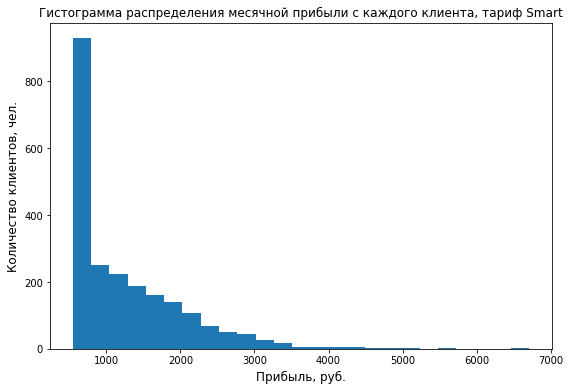

In [104]:
# Построим гистограмму помесячной прибыли компании по тарифу Смарт

smart_stats['revenue_total'].plot(kind = 'hist',
                                      bins = 25,
                                      figsize = (9, 6)).set_title('Гистограмма распределения месячной прибыли с каждого клиента, тариф Smart')
plt.xlabel('Прибыль, руб.', fontsize=12)
plt.ylabel('Количество клиентов, чел.', fontsize=12)
plt.show()

По гистограмме видно, что не менее половины пользователей тарифа значительно выходят за рамки абонентской платы, оплачивая дополнительные услуги по минутам, СМС и интернету, увеличивая доход в два  и более раз.  

In [105]:
# Получим средний размер прибыли

smart_stats['revenue_total'].mean()

1233.3494665489009

In [106]:
# Рассчитаем дисперсию

smart_stats['revenue_total'].var()

620452.6075337975

In [107]:
# Получим стандартное отклонение

smart_stats['revenue_total'].std()

787.6881410392043

## Тариф УЛЬТРА

### Длительность звонков

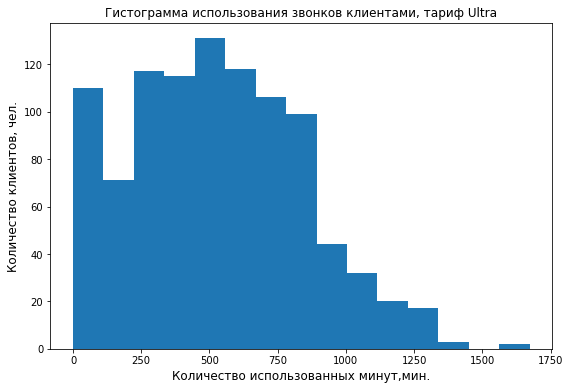

In [108]:
# Для наглядности представления данных построим гистограмму по полученным данным

ultra_stats['minutes_total'].plot(kind = 'hist', 
                                                   bins = 15, 
                                                   figsize = (9, 6)).set_title('Гистограмма использования звонков клиентами, тариф Ultra')
plt.xlabel('Количество использованных минут,мин.', fontsize=12)
plt.ylabel('Количество клиентов, чел.', fontsize=12)
plt.show()

Гистограмма по своей форме стремится к виду нормального распределения.

In [109]:
# Получим среднее количество израсходованных минут

ultra_stats['minutes_total'].mean()

526.6233502538071

In [110]:
# Сделаем расчет дисперсии средней длительности звонков

ultra_stats['minutes_total'].var()

100873.63339730098

In [111]:
# Рассчитаем стандартное отклонение длительности звонков 

ultra_stats['minutes_total'].std()

317.6060978591264

### Количество сообщений

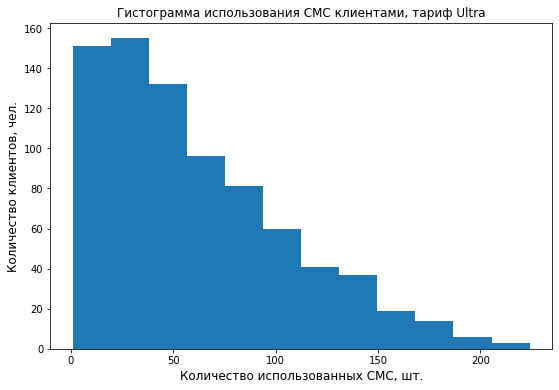

In [112]:
# Представим полученные данные в виде гистограммы

messages_stats_ultra['sms_total'].plot(kind = 'hist', 
                                       bins = 12, 
                                       figsize = (9, 6)).set_title('Гистограмма использования СМС клиентами, тариф Ultra')
plt.xlabel('Количество использованных СМС, шт.', fontsize=12)
plt.ylabel('Количество клиентов, чел.', fontsize=12)
plt.show()

Распределение близко к Пуассоновскому. Нечеткость формы определяется слишком малым количеством данных . При увеличении количества сведений данная гистограмма будет стремиться к нормальному виду.

In [113]:
# Считаем среднее по количеству СМС

messages_stats_ultra['sms_total'].mean()

61.161006289308176

In [114]:
# Рассчитаем годовую дисперсию

messages_stats_ultra['sms_total'].var()

2109.6591828652

In [115]:
# Получим стандартное отклонение

messages_stats_ultra['sms_total'].std()

45.931026364160424

### Интернет-трафик

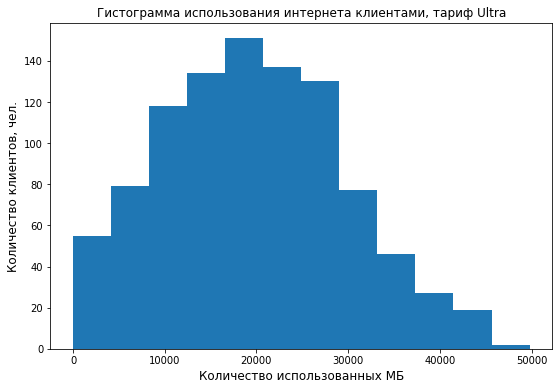

In [116]:
# Построим гистограмму

internet_stats_ultra['mb_total'].plot(kind = 'hist',
                                      bins = 12,
                                      figsize = (9, 6)).set_title('Гистограмма использования интернета клиентами, тариф Ultra')
plt.xlabel('Количество использованных МБ', fontsize=12)
plt.ylabel('Количество клиентов, чел.', fontsize=12)
plt.show()

Гистограмма имеет выраженное стремление к виду нормального распределения.

In [117]:
# Считаем среднее по расходу трафика

internet_stats_ultra['mb_total'].mean()

19686.76717948718

In [118]:
# Рассчитаем дисперсию

internet_stats_ultra['mb_total'].var()

99043439.60795662

In [119]:
# Получим стандартное отклонение

internet_stats_ultra['mb_total'].std()

9952.057054094726

### Доход по тарифу

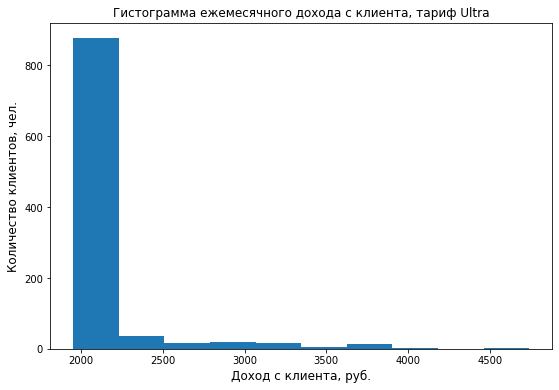

In [120]:
# Построим гистограмму помесячной прибыли компании по тарифу Ультра

ultra_stats['revenue_total'].plot(kind = 'hist',
                                      bins = 10,
                                      figsize = (9, 6)).set_title('Гистограмма ежемесячного дохода с клиента, тариф Ultra')
plt.xlabel('Доход с клиента, руб.', fontsize=12)
plt.ylabel('Количество клиентов, чел.', fontsize=12)
plt.show()

Полученная гистограмма демонстрирует, что доход от тарифа достаточно стабилен и концентрируется вокруг абонентской платы по тарифу.

In [121]:
# Получим среднее количество прибыли

ultra_stats['revenue_total'].mean()

2060.5299710501267

In [122]:
# Рассчитаем дисперсию

ultra_stats['revenue_total'].var()

126953.2854599396

In [123]:
# Получим стандартное отклонение

ultra_stats['revenue_total'].std()

356.30504551569237

## Вывод по разделу

На данном этапе были рассчитаны такие показатели, как ежемесячные показатели количества потраченных минут, СМС и объема интернет-трафика для каждого, параметры прибыли по каждому из тарифов. Построенные гистограммы стремятся к нормальному виду, что говорит об адекватности имеющихся данных. Данные наблюдения в дальнейшем позволяют нам делать оценку всей генеральной совокупности и провести проверку гипотез о равенстве средних значений прибыли компании.
    
Отдельно оценены среднее, дисперсия и стандартное отклонение указанных параметров. 

# Проверка гипотез

## Гипотеза о равенстве средних значений выручки двух тарифов

In [124]:
# Выбираем нулевую гипотезу: H0 - "средние значения по прибыли компании по тарифу Smart
# и Ultra равны". Тогда альтернативная гипотеза имеет вид H1 - "средние значения по прибыли компании 
# по тарифу Smart и Ultra не равны". Это сейчас и проверим.

alpha = 0.05 # величина уровня статистической значимости p-value

results = st.ttest_ind(smart_stats['revenue_total'], ultra_stats['revenue_total'])

if results.pvalue < alpha:
    print('P-value = {}. Уровень статистической значимости не достигнут. Есть повод отвергнуть H_0'.format(results.pvalue))
else:
    print('P-value = {}. Уровень статистической значимости выше установленного порога. Не удалось отвергнуть H_0'.format(results.pvalue))

P-value = 1.172655564462924e-190. Уровень статистической значимости не достигнут. Есть повод отвергнуть H_0


**Вывод**

Уровень порога для P-value в 5% преодолен не был. Таким образом, мы не можем подтвердить, что средний уровень прибыли по двум тарифам является одинаковым. Из этого делаем вывод о большой вероятности того, что эти показатели будут различными, что соответствует выдвинутой в задании гипотезе. 

## Гипотеза о равенстве средних значений общей выручки компании в Москве и в других городах

### Общий доход

In [125]:
# Объединим данные по двум тарифам

stats_total = smart_stats.merge(ultra_stats, 
                                how = 'outer',
                                left_index=True, 
                                right_index=True, 
                                suffixes=('_smart', '_ultra'))

In [126]:
# Создадим новый столбец, который будет содержать доходы по обоим тарифам

stats_total['revenue_total'] = stats_total['revenue_total_smart'].fillna(0)+stats_total['revenue_total_ultra'].fillna(0)

In [127]:
# Проверим результат

stats_total

minutes_total_smart  minutes_revenue_smart  \
user_id month tariff city                                                      
1000    5.0   ultra  Краснодар                    NaN                    NaN   
        6.0   ultra  Краснодар                    NaN                    NaN   
        7.0   ultra  Краснодар                    NaN                    NaN   
        8.0   ultra  Краснодар                    NaN                    NaN   
        9.0   ultra  Краснодар                    NaN                    NaN   
...                                               ...                    ...   
1498    10.0  smart  Владикавказ                247.0                    0.0   
1499    9.0   smart  Пермь                       70.0                    0.0   
        10.0  smart  Пермь                      449.0                    0.0   
        11.0  smart  Пермь                      612.0                  336.0   
        12.0  smart  Пермь                      492.0                    0.0   

                                  calls_count  sms_revenue_smart  \
user_id month tariff city                                          
1000    5.0   ultra  Краснодар            NaN                NaN   
        6.0   ultra  Краснодар            NaN                NaN   
        7.0   ultra  Краснодар            NaN                NaN   
        8.0   ultra  Краснодар            NaN                NaN   
        9.0   ultra  Краснодар            NaN                NaN   
...                                       ...                ...   
1498    10.0  smart  Владикавказ         30.0                0.0   
1499    9.0   smart  Пермь                8.0                0.0   
        10.0  smart  Пермь               44.0                0.0   
        11.0  smart  Пермь               62.0               27.0   
        12.0  smart  Пермь               56.0               48.0   

                                  mb_revenue_smart  revenue_total_smart  \
user_id month tariff city                                                 
1000    5.0   ultra  Краснодар                 NaN                  NaN   
        6.0   ultra  Краснодар                 NaN                  NaN   
        7.0   ultra  Краснодар                 NaN                  NaN   
        8.0   ultra  Краснодар                 NaN                  NaN   
        9.0   ultra  Краснодар                 NaN                  NaN   
...                                            ...                  ...   
1498    10.0  smart  Владикавказ       1024.218750          1574.218750   
1499    9.0   smart  Пермь                0.000000           550.000000   
        10.0  smart  Пермь              478.320312          1028.320312   
        11.0  smart  Пермь              512.500000          1425.500000   
        12.0  smart  Пермь                0.000000           598.000000   

                                  minutes_total_ultra  minutes_revenue_ultra  \
user_id month tariff city                                                      
1000    5.0   ultra  Краснодар                  159.0                    0.0   
        6.0   ultra  Краснодар                  172.0                    0.0   
        7.0   ultra  Краснодар                  340.0                    0.0   
        8.0   ultra  Краснодар                  408.0                    0.0   
        9.0   ultra  Краснодар                  466.0                    0.0   
...                                               ...                    ...   
1498    10.0  smart  Владикавказ                  NaN                    NaN   
1499    9.0   smart  Пермь                        NaN                    NaN   
        10.0  smart  Пермь                        NaN                    NaN   
        11.0  smart  Пермь                        NaN                    NaN   
        12.0  smart  Пермь                        NaN                    NaN   

                                  sms_revenue_ultra  mb_revenue_ultra  \
user_id month tari

In [128]:
# Делаем срез доходов по компании по Москве

revenue_moscow = stats_total['revenue_total'][stats_total.index.get_level_values(3) == 'Москва']


In [129]:
# Проверяем результат

revenue_moscow.head()

user_id  month  tariff  city  
1001     11.0   smart   Москва    1153.90625
         12.0   smart   Москва     550.00000
1003     8.0    ultra   Москва    1950.00000
         9.0    ultra   Москва    1950.00000
         10.0   ultra   Москва    1950.00000
Name: revenue_total, dtype: float64

In [130]:
# Делаем срез доходов по компании по другим городам

revenue_not_moscow = stats_total['revenue_total'][stats_total.index.get_level_values(3) != 'Москва']

In [131]:
# Проверяем результат

revenue_not_moscow.head()

user_id  month  tariff  city     
1000     5.0    ultra   Краснодар    1950.0
         6.0    ultra   Краснодар    1950.0
         7.0    ultra   Краснодар    1950.0
         8.0    ultra   Краснодар    1950.0
         9.0    ultra   Краснодар    1950.0
Name: revenue_total, dtype: float64

In [132]:
# Выбираем нулевую гипотезу H0: "средние значения прибыли компании в Москве и прибыли
# в других городах равны". 
# Тогда альтернативная гипотеза H1: "средние значения прибыли компании 
# в Москве и в других городах не равны".

alpha = 0.05 # Уровень статистической значимости P-value

results = st.ttest_ind(revenue_moscow, revenue_not_moscow)

if results.pvalue < alpha:
    print('P-value = {}. Уровень статистической значимости не достигнут. Есть повод отвергнуть H_0'.format(results.pvalue))
else:
    print('P-value = {}. Уровень статистической значимости выше установленного порога. Не удалось отвергнуть H_0'.format(results.pvalue))

P-value = 0.47443187631524797. Уровень статистической значимости выше установленного порога. Не удалось отвергнуть H_0


**Вывод**

Вероятность того, что выручка компании в Москве равна прибыли в остальных городах оказалась велика. Таким образом, мы можем предположить, что средний уровень прибыли компании в Москве и в других городах не различается.


## Вывод по разделу

В данном разделе были проверены две гипотезы:
- средняя выручка от пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка от пользователей из Москвы отличается от выручки от пользователей из других регионов.
   
Эти гипотезы были приняты за альтернативные, а в качестве нулевых выдвинуты следующие:
- для первого случая: средние выручки от пользователей тарифов «Ультра» и «Смарт» равны;
- для второго случая: средняя выручка от пользователей из Москвы равна выручке от пользователей из других регионов.
    
В первом случае нулевая гипотеза была отвергнута, а во втором нулевую гипотезу отвергнуть не удалось. Это позволяет строить предположения о том, что:
- средняя выручка от пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка от пользователей из Москвы не отличается от выручки от пользователей из других регионов.
    
Для оценки гипотез использовался уровень статистической значимости Alpha = 0.05.

# Общий вывод по проекту

В ходе данной работы были проанализированы выборки статистических данных о пользователях телекоммуникационной компании "Мегалайн" в 2018 году. В качестве входных данных предоставлялись датасеты об использовании телефонных звонков, СМС-сообщений и интернет-трафика по двум тарифным планам - "Смарт" и "Ультра". Сведения об условиях данных тарифов предоставлены в отдельной таблице. О каждом из пользователей дана краткая справка (место жительства, фамилия, имя и т.д.) в виде таблицы.
    
На первом этапе были загружены необходимые инстументы для работы с имеющимися сведениями, сами датасеты, проведен первичный анализ с целью выявления возможных ошибок в данных, даны рекомендации по дальнейшей обработке содержимого таблиц.
    
Во втором разделе проекта произведена коррекция типов данных для удобства работы с ними в дальнейшем, округлены значения потраченных минут разговоров и интернет-трафика для тарификации и начисления платы по ним. Попарно объединены данные о звонках, СМС и интернете с таблицей о пользователях, что позволило в дальнейшем сопоставить каждого юзера с его действиями. Посчитаны ежемесячные траты клиентов по минутам разговоров, СМС и мегабайт интернет-трафика сверх включенного в тарифы лимита. Рассчитаны итоговые доходы компании по всем услугам связи по обоим тарифам.
    
В третьем разделе работы проведен расчет средних показателей дохода компании за год с каждого пользователя. Рассчитаны значения дисперсии и стандартного отклонения по каждому из параметров
    
На финальной стадии проекта проведены оценки гипотез о различии среднего уровня доходов тарифов "Смарт" и "Ультра", а также о разнице средних доходов компании по Москве и по другим городам. Для этого были выдвинуты следующие "нулевые гипотезы":
- для первого случая: средние выручки пользователей тарифов «Ультра» и «Смарт» равны;
- средняя выручка пользователей из Москвы равна выручке от пользователей из других регионов.

В первом случае нулевая гипотеза была отвергнута, что позволяет сказать о высокой вероятности различия средних величин дохода по тарифам. 
    
Во втором случае нулевую гипотезу отвергнуть не удалось, что дает нам право сказать о высокой вероятности опровержения поставленной по заданию второй гипотезы. 
    
        
Данное исследование показало, что на тарифе "Ультра" пользователи не вырабатывают предоставленный лимит по минутам и СМС, но иногда выходят за пределы лимита по интернет-трафику. Таким образом, доход от тарифа строится, в основном, на абонентской плате, а влияние на него оплаты дополнительных минут, СМС и мегабайтов мал. Средний показатель прибыли по тарифу - 2060.5 руб. при абонентской плате в 1950 руб. и стандартном отклонении 356.3 руб. Это говорит о стабильности данного тарифного плана в принесении достаточно высокого уровня прибыли. 
    
По тарифу "Смарт" же совершенно иная информация. Пользователям часто не хватает включенных в тариф бесплатных минут, СМС и мегабайт. Это приводит к тому, что они чаще совершают переплаты, которые достигают 3-4 значений абонентской платы. Среднее значение прибыли по тарицу составляет 1233 руб. при достаточно высоком стандартном отклонении - 787.6 руб., что говорит о нестабильности этого значения. Думаю, что дополнительной рекламы для такого тарифа не потребуется, так как потенциальные клиенты и так будут выбирать подешевле, не вдумываясь в то, что им предстоят значительные дополнительные расходы.
    
Учитывая изложенное выше, полагаю, что необходимо уделить внимание продвижению тарифа Ультра, так как он стабильно приносит больше денег, чем Смарт. При создании рекламы можно разъяснять пользователям, что на этом тарифном плане они платят один раз и не задумываются о том, что выйдут за пределы предусмотренного лимита, а, значит, будут иметь возможность точно контролировать свои расходы. К тому же, можно предусмотреть возможности для перевода минут в мегабайты или наоборот, чтобы каждый пользователь мог гибко настраивать тариф под себя, что будет дополнительно привлекать клиентов.